In [140]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelV2

In [66]:
using OhMyThreads
using ProgressMeter
using JLD2
using ColorSchemes

In [60]:
includet("../../scripts/figures_util.jl")

using GLMakie
using CairoMakie
CairoMakie.activate!()

# Setup

## Colorings

In [67]:
module MMAnalysisColors
using ColorSchemes
using Makie

ext1 = ColorSchemes.Blues[5]
ext2 = ColorSchemes.Blues[7]
ext3 = ColorSchemes.Blues[9]
stable1 = ColorSchemes.Oranges[4]
stable2 = ColorSchemes.Oranges[5]
unstable1 = ColorSchemes.Greens[4]
unstable2 = ColorSchemes.Greens[5]

other = ColorSchemes.Dark2_4[end]

all = [ext1, ext2, ext3, stable1, stable2, unstable1, unstable2]
markerelements = [MarkerElement(; color=c, marker=:rect) for c in all]

end

function mma_result_coloring1(st::Int)
    map_ = Dict(
        0 => MMAnalysisColors.ext1,
        1 => MMAnalysisColors.ext2,
        11 => MMAnalysisColors.ext3,
        2 => MMAnalysisColors.stable1,
        12 => MMAnalysisColors.stable2,
        3 => MMAnalysisColors.unstable1,
        13 => MMAnalysisColors.unstable2,
    )

    get(map_, st, MMAnalysisColors.other)
end
function mma_result_coloring1_leg()
    yy = [
        "Extinct 1",
        "Extinct 2",
        "Extinct 3",
        "Stable 1",
        "Stable 2",
        "Unstable 1",
        "Unstable 2",
    ]

    MMAnalysisColors.markerelements, yy
end
function mma_result_coloring1_leg_longer()
    yy = [
        "Extinct 1 - no positive real sols",
        "Extinct 2 - one posreal sol, nospace unstable",
        "Extinct 3 - two posreal sols, both nospace unstable",
        "Stable 1 - one posreal sol, spatially stable",
        "Stable 2 - two posreal sols, one nospace unstable and one spatially stable",
        "Unstable 1 - one posreal sol, spatially unstable",
        "Unstable 2 - two posteal sols, one nospace unstable and one spatially unstable",
        "Other - anything else",
    ]

    [MMAnalysisColors.markerelements; MarkerElement(; color=MMAnalysisColors.other, marker=:rect)], yy
end

function mma_result_coloring2(st::Int)
    map_ = Dict(
        0 => MMAnalysisColors.ext1,
        1 => MMAnalysisColors.ext2,
        11 => MMAnalysisColors.ext3,
        2 => MMAnalysisColors.stable1,
        12 => MMAnalysisColors.stable1,
        3 => MMAnalysisColors.unstable1,
        13 => MMAnalysisColors.unstable1,
    )

    get(map_, st, MMAnalysisColors.other)
end
function mma_result_coloring2_leg()
    xx = MMAnalysisColors.markerelements[[1, 2, 3, 4, 6]]
    yy = [
        "Extinct 1",
        "Extinct 2",
        "Extinct 3",
        "Stable",
        # "Stable 2",
        "Unstable",
        # "Unstable 2",
    ]

    xx, yy
end

mma_result_coloring2_leg (generic function with 1 method)

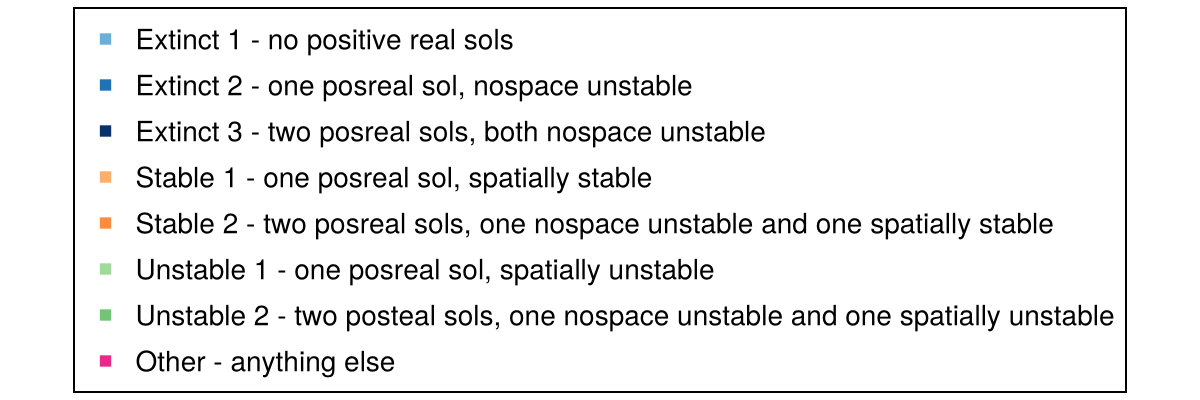

In [68]:
fig = Figure(; size=(600, 200))
Legend(fig[1,1], mma_result_coloring1_leg_longer()...)

Makie.save("../../figures/fig2/full_legend.pdf", fig)

fig

## K v l phase diagram

In [94]:
function do_Kl_pd_run(logKs, epsilons;
    m=1.,
    k=0.,
    c=1.,
    d=1.,
    r=1.,
    DN=1e-12, DI=1., DR=1.,
    return_raw=false,
)
    rslts = Matrix{Vector{NospaceSolStability.T}}(undef, length(logKs), length(epsilons))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, e) in enumerate(epsilons)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m,
                    l=(1-e),
                    k,
                    c,
                    d,
                    r,
                );
                DN, DI, DR,
            )
        end
    end
    if return_raw
        rslts
    else
        nospacesolstabilities_to_code.(rslts)
    end
end

do_Kl_pd_run (generic function with 1 method)

In [100]:
function plot_Kl_pd!(ax, logKs, epsilons;
    m=1.,
    k=0.,
    c=1.,
    d=1.,
    r=1.,
    DN=1e-8, DI=1.0, DR=1e-8,
    include_legend=true,
    do_decorations=true,
    coloring=2,
    kwargs...
)
    codes = do_Kl_pd_run(logKs, epsilons; m, k, c, d, r, DN, DI, DR)
    
    cfunc, cleg = if coloring == 1
        mma_result_coloring1, mma_result_coloring1_leg
    elseif coloring == 2
        mma_result_coloring2, mma_result_coloring2_leg
    end
    colors = cfunc.(codes)
    
    hm = heatmap!(ax, logKs, epsilons, colors; kwargs...)
    
    if (do_decorations == true) || (do_decorations == :basic)
        ax.xlabel = L"\log_{10}(K)"
        ax.ylabel = L"l_\text{influx}"
    elseif do_decorations == :complex
        # ax.xlabel = L"K"
        ax.ylabel = L"l_\text{influx}"
    end

    if include_legend
        axislegend(ax, cleg()...)
    end
    
    hm
end

plot_Kl_pd! (generic function with 1 method)

# PD with logistic l

In [203]:
function make_eps_ticks(low, high, N)
    xl = LeakageScale.etox(low)
    xh = LeakageScale.etox(high)
    xs = range(xl, xh, N)
    epsilons = LeakageScale.e.(xs)
    xs, [(@sprintf "%.2g" e) for e in epsilons]
end

function make_eps_ticks2(low, high, N)
    epsilons = range(low, high, N)
    LeakageScale.etox.(epsilons), [(@sprintf "%.2g" e) for e in epsilons]
end

make_eps_ticks2 (generic function with 1 method)

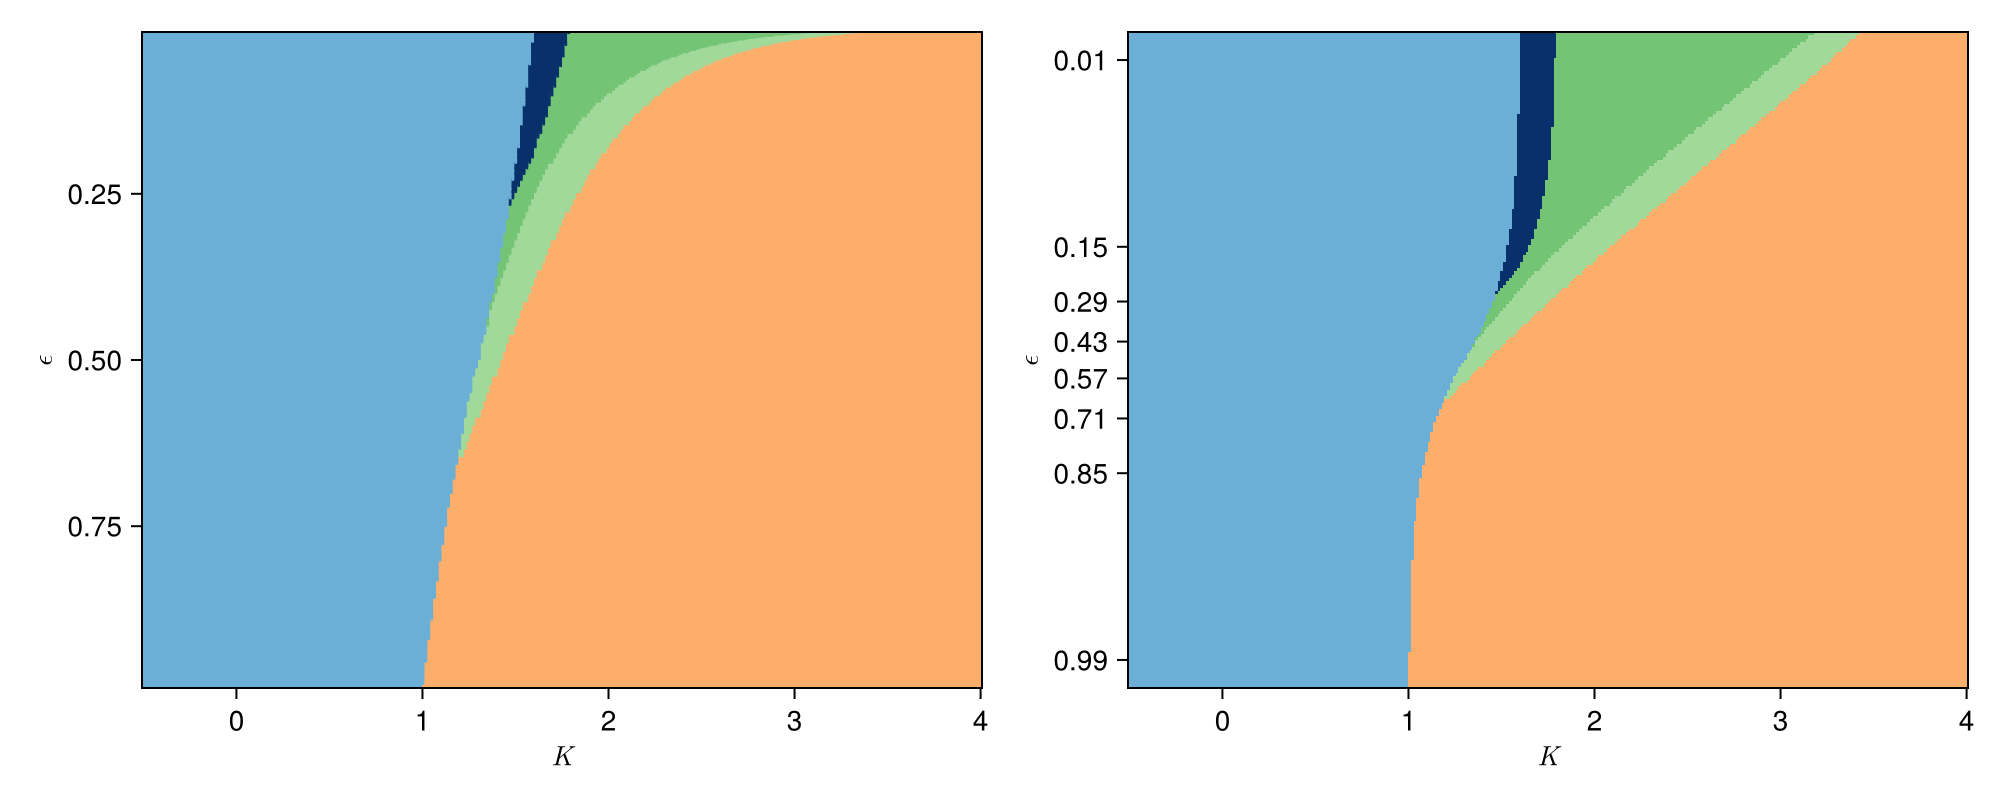

In [206]:
logKs = range(-0.5, 4, 300)
leak_xs = range(-5, 5, 200)
epsilons = LeakageScale.e.(leak_xs)

xx = do_Kl_pd_run(logKs, epsilons;
    m=10.,
    DR=0.5,
)
cs = mma_result_coloring1.(xx)

fig = Figure(; size=(1000, 400))
ax1 = Axis(fig[1,1];
    xlabel=L"K",
    ylabel=L"\epsilon",
    yreversed=true,
)
ax2 = Axis(fig[1,2];
    xlabel=L"K",
    # ylabel=L"x = \log(\frac{l=1-\epsilon}{\epsilon})",
    ylabel=L"\epsilon",
    yticks=make_eps_ticks2(0.01, 0.99, 8)
    # yticks=make_eps_ticks(extrema(epsilons)..., 5)
)
heatmap!(ax1, logKs, epsilons, cs)
heatmap!(ax2, logKs, leak_xs, cs)

Makie.save("../../figures/fig2/logistic_leakage.pdf", fig)

fig

# PD with analytic lines

In [115]:
function make_full_pd_fig(logKs, epsilons;
    m=1., c=1., r=1.,
    d=c,
    DN=1e-12,
    DI=1., DR=1.,
)
    fig = Figure(;
        size=(double_col_width * 0.25, double_col_width * 0.25),
        default_fig_kwargs...,
        # figure_padding=tuple(fill(3., 4))
        figure_padding=(2., 8., 2., 2.)
    )
    
    ax = Axis(fig[1,1];
        aspect=AxisAspect(1.)
    )
    
    hm = plot_Kl_pd!(ax, logKs, epsilons;
        k=0.,
        m, c, r, d,
        DN, DI, DR,
        include_legend=false,
        do_decorations=false,
        coloring=1,
        rasterize=3,
    )
    
    pp = -2:6
    ax.xticks = (pp, [rich("10", superscript(string(e))) for e in pp])
    ax.xlabelpadding = 0.
    ax.xlabel = L"K,\enspace\text{Amount of energy being supplied}"
    
    # ax.yticks = 0.:0.25:1.
    ax.ylabelpadding = 0.
    ax.ylabel = L"\epsilon_\text{influx},\enspace\text{Influx resource usage}"
    
    # Makie.save("../../figures/fig2/pd3.pdf", fig)
    
    FigureAxisAnything(fig, ax, [])
end
function make_pd_with_lines(logKs, epsilons;
    m=1., c=1., r=1.,
    d=c,
    DN=1e-12,
    DI=1., DR=1.
)
    if c != d
        @warn "When d != c the FR lines are expected to be wrong"
    end
    faa = make_full_pd_fig(logKs, epsilons; m, c, d, r, DN, DI, DR)

    extline_Ks = map(epsilons) do e
        if e < 0.5
            4 * (1-e) * m * r / c
        else
            m * r / (c * e)
        end
    end;
    fr_spatial_instab_Ks = map(epsilons) do e
        if e < 0.5
            m * r / (c * e)
        else
            missing
        end
    end;
    
    lines!(faa.axis, log10.(extline_Ks), epsilons;
        color=ColorSchemes.Dark2_6[end-4],
        linewidth=1.,
    )
    lines!(faa.axis, clamp.(log10.(fr_spatial_instab_Ks), -Inf, maximum(logKs)), epsilons;
        color=ColorSchemes.Dark2_6[end-3],
        linewidth=1.,
    )

    xlims!(faa.axis, extrema(logKs)...)
    ylims!(faa.axis, extrema(epsilons)...)

    faa
end

make_pd_with_lines (generic function with 1 method)

## Full

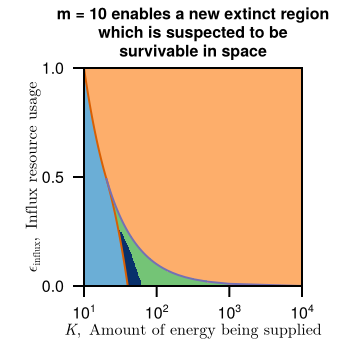

In [125]:
N = 1000
logKs = range(1., 4, 300)
epsilons = range(0, 1, 100)

do_Kl_pd_run(logKs, epsilons)

pd_params = (;
    m=10., c=1., r=1.,
    d=1.,
    DN=1e-12,
    DI=1., DR=1.,
)

faa = make_pd_with_lines(logKs, epsilons; pd_params...)
faa.axis.title = "m = 10 enables a new extinct region\nwhich is suspected to be\nsurvivable in space"

Makie.save("../../figures/fig2/pdv2_t4.pdf", faa.figure)

faa

## Just plotting lines

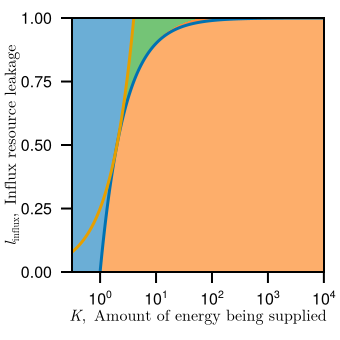

In [96]:
N = 1000
logKs = range(-0.5, 4, N)
lis = range(0, 1, N)

pd_params = (;
    m=1., c=1., r=1.,
    DN=1e-8,
    DI=1.0, DR=1.,
)

faa = make_full_pd_fig(logKs, lis; pd_params...)

l1s = 1 .- (pd_params.m ./ (10 .^ logKs))
l2s = (10 .^ logKs) ./ (4 * pd_params.m)

lines!(faa.axis, logKs, l1s)
lines!(faa.axis, logKs, l2s)

ylims!(faa.axis, (0., 1.))

# display(GLMakie.Screen(), faa.figure)

faa

In [97]:
display(GLMakie.Screen(), faa.figure)

GLMakie.Screen(...)

# Diffusion heatmap

In [25]:
DIs = 10 .^ range(-12, 1, 30)
DRs = 10 .^ range(-12, 1, 30)

logKs = range(-0.5, 3, 100)
ls = range(0., 1., 100)

props = Matrix{Float64}(undef, length(DIs), length(DRs))
pb = Progress(length(props))
for i in 1:length(DIs)
    for j in 1:length(DRs)
        rslts = Matrix{Any}(undef, length(logKs), length(ls))
        @tasks for Ki in 1:length(logKs)
            logK = logKs[Ki]
            for (li, l) in enumerate(ls)
                rslts[Ki, li] = analyse_mmp(
                    MMParams(;
                        K=10 ^ logK,
                        m=1.,
                        l=l,
                        k=0.,
                        c=1.,
                        d=1.,
                    );
                    DN=1e-12,
                    DI=DIs[i],
                    DR=DRs[j],
                )
            end
        end
        codes = nospacesolstabilities_to_code.(rslts)
        num_unstable = count(x->(x == 3) || (x == 13), codes)
        props[i, j] =  num_unstable / length(codes)
        next!(pb)
    end
end
finish!(pb)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


In [29]:
# jldsave("./figures_data/mm_diff_pd_temp.jld2"; DIs, DRs, logKs, ls, props)

In [49]:
@load "./figures_data/mm_diff_pd.jld2" DIs DRs props;

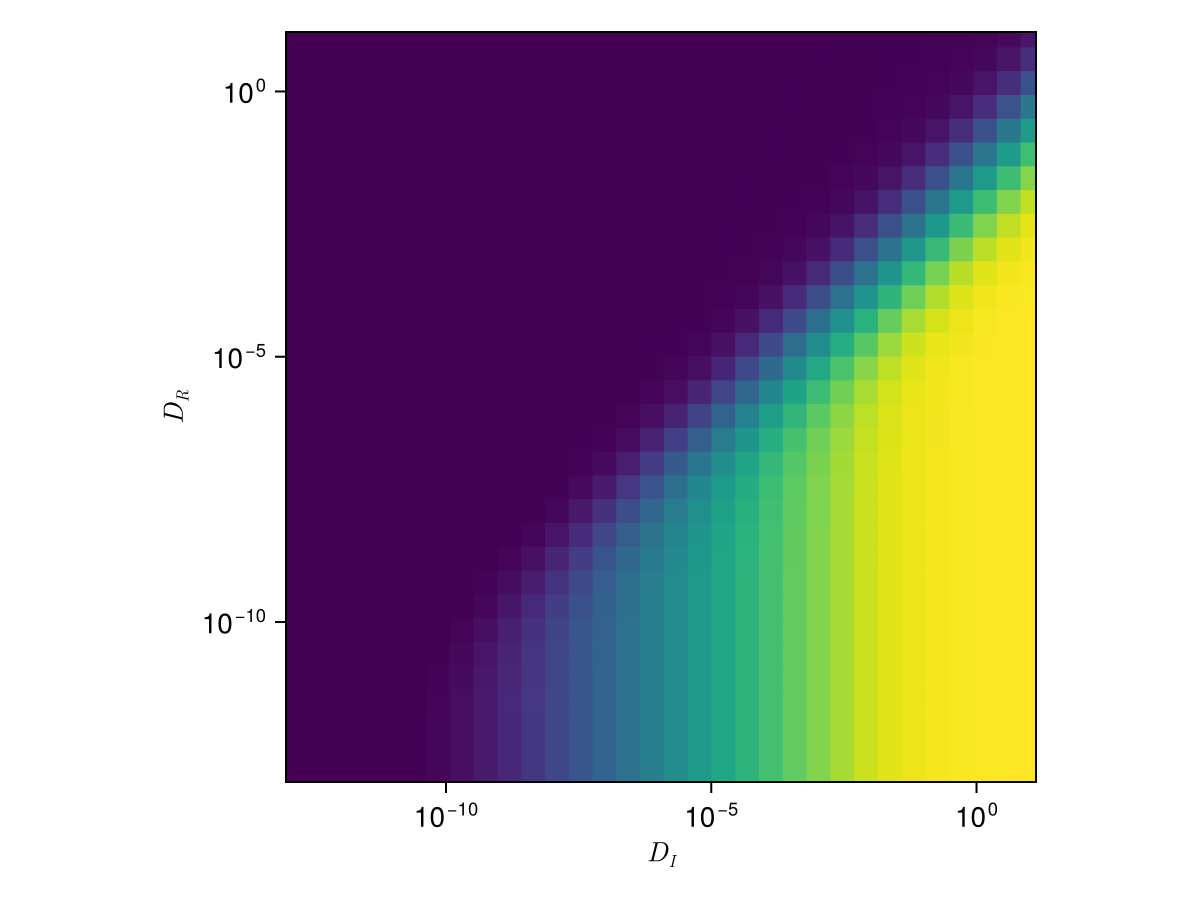

In [50]:
heatmap(DIs, DRs, props;
    axis=(;
        aspect=DataAspect(),
        xlabel=L"D_I",
        ylabel=L"D_R",
        xscale=log10,
        yscale=log10,
    )
)

# Changing both DI and DR together

In [94]:
Ds = 10 .^ range(-12, 1, 20)

logKs = range(-0.5, 3, 100)
ls = range(0., 1., 100)

D_props = []
for D in Ds
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=1e-12,
                DI=D,
                DR=D,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(D_props, num_unstable / length(codes))
end

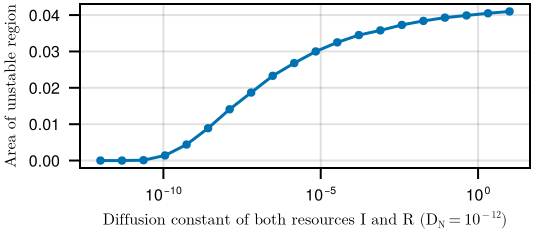

In [95]:
fig = Figure(;
    size=(double_col_width * 0.4, double_col_width * 0.17),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 2.)
)
ax = Axis(fig[1,1];
    ylabel=L"\text{Area of unstable region}",
    xlabel=L"\text{Diffusion constant of both resources $I$ and $R$ ($D_N = 10^{-12}$)}",
    xscale=log10,
)

scatterlines!(ax, Ds, D_props)

Makie.save("../../figures/fig2/DI_DR_diffusionplot.pdf", fig)

fig

# OLD
# OLD
# OLD
# OLD
# OLD

# PD for figure 2

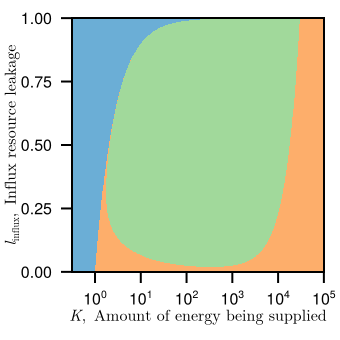

In [9]:
fig = Figure(;
    size=(double_col_width * 0.25, double_col_width * 0.25),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 2.)
)

ax = Axis(fig[1,1];
    aspect=AxisAspect(1.)
)

N = 1000
hm = plot_Kl_pd!(ax, range(-0.5, 5, N), range(0, 1, N);
    m=1.,
    d=0.001,
    include_legend=false,
    do_decorations=false,
    rasterize=3,
)

pp = -2:6
ax.xticks = (pp, [rich("10", superscript(string(e))) for e in pp])
ax.xlabelpadding = 0.
ax.xlabel = L"K,\enspace\text{Amount of energy being supplied}"

ax.yticks = 0.:0.25:1.
ax.ylabelpadding = 0.
ax.ylabel = L"l_\text{influx},\enspace\text{Influx resource leakage}"

Makie.save("../../figures/fig2/pd3.pdf", fig)

fig

# Changing individual diffusion constants

## Get the data

In [7]:
DIs = 10 .^ range(1, -12, 20)
DNs = 10 .^ range(1, -12, 20)
DRs = 10 .^ range(1, -12, 20)

logKs = range(-0.5, 3, 100)
ls = range(0., 1., 100)

DI_props = []
for DI in DIs
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=1e-12,
                DI=DI,
                DR=1e-12,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(DI_props, num_unstable / length(codes))
end
DN_props = []
for DN in DNs
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=DN,
                DI=1.,
                DR=1e-12,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(DN_props, num_unstable / length(codes))
end
DR_props = []
for DR in DRs
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=1e-12,
                DI=1.,
                DR=DR,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(DR_props, num_unstable / length(codes))
end

## Make the plot

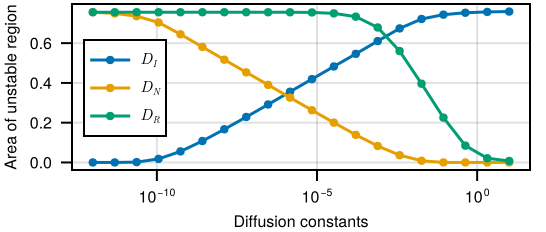

In [57]:
fig = Figure(;
    size=(double_col_width * 0.4, double_col_width * 0.17),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 2.)
)
ax = Axis(fig[1,1];
    ylabel="Area of unstable region",
    xlabel="Diffusion constants",
    xscale=log10,
)

scatterlines!(ax, DIs, DI_props; label=L"D_I")
scatterlines!(ax, DNs, DN_props; label=L"D_N")
scatterlines!(ax, DRs, DR_props; label=L"D_R")

axislegend(ax;
    position=:lc,
    rowgap=-6.,
    padding=(3., 3., 0., 0.),
)

Makie.save("../../figures/fig2/diffusions.pdf", fig)

fig

# Tiling K v l

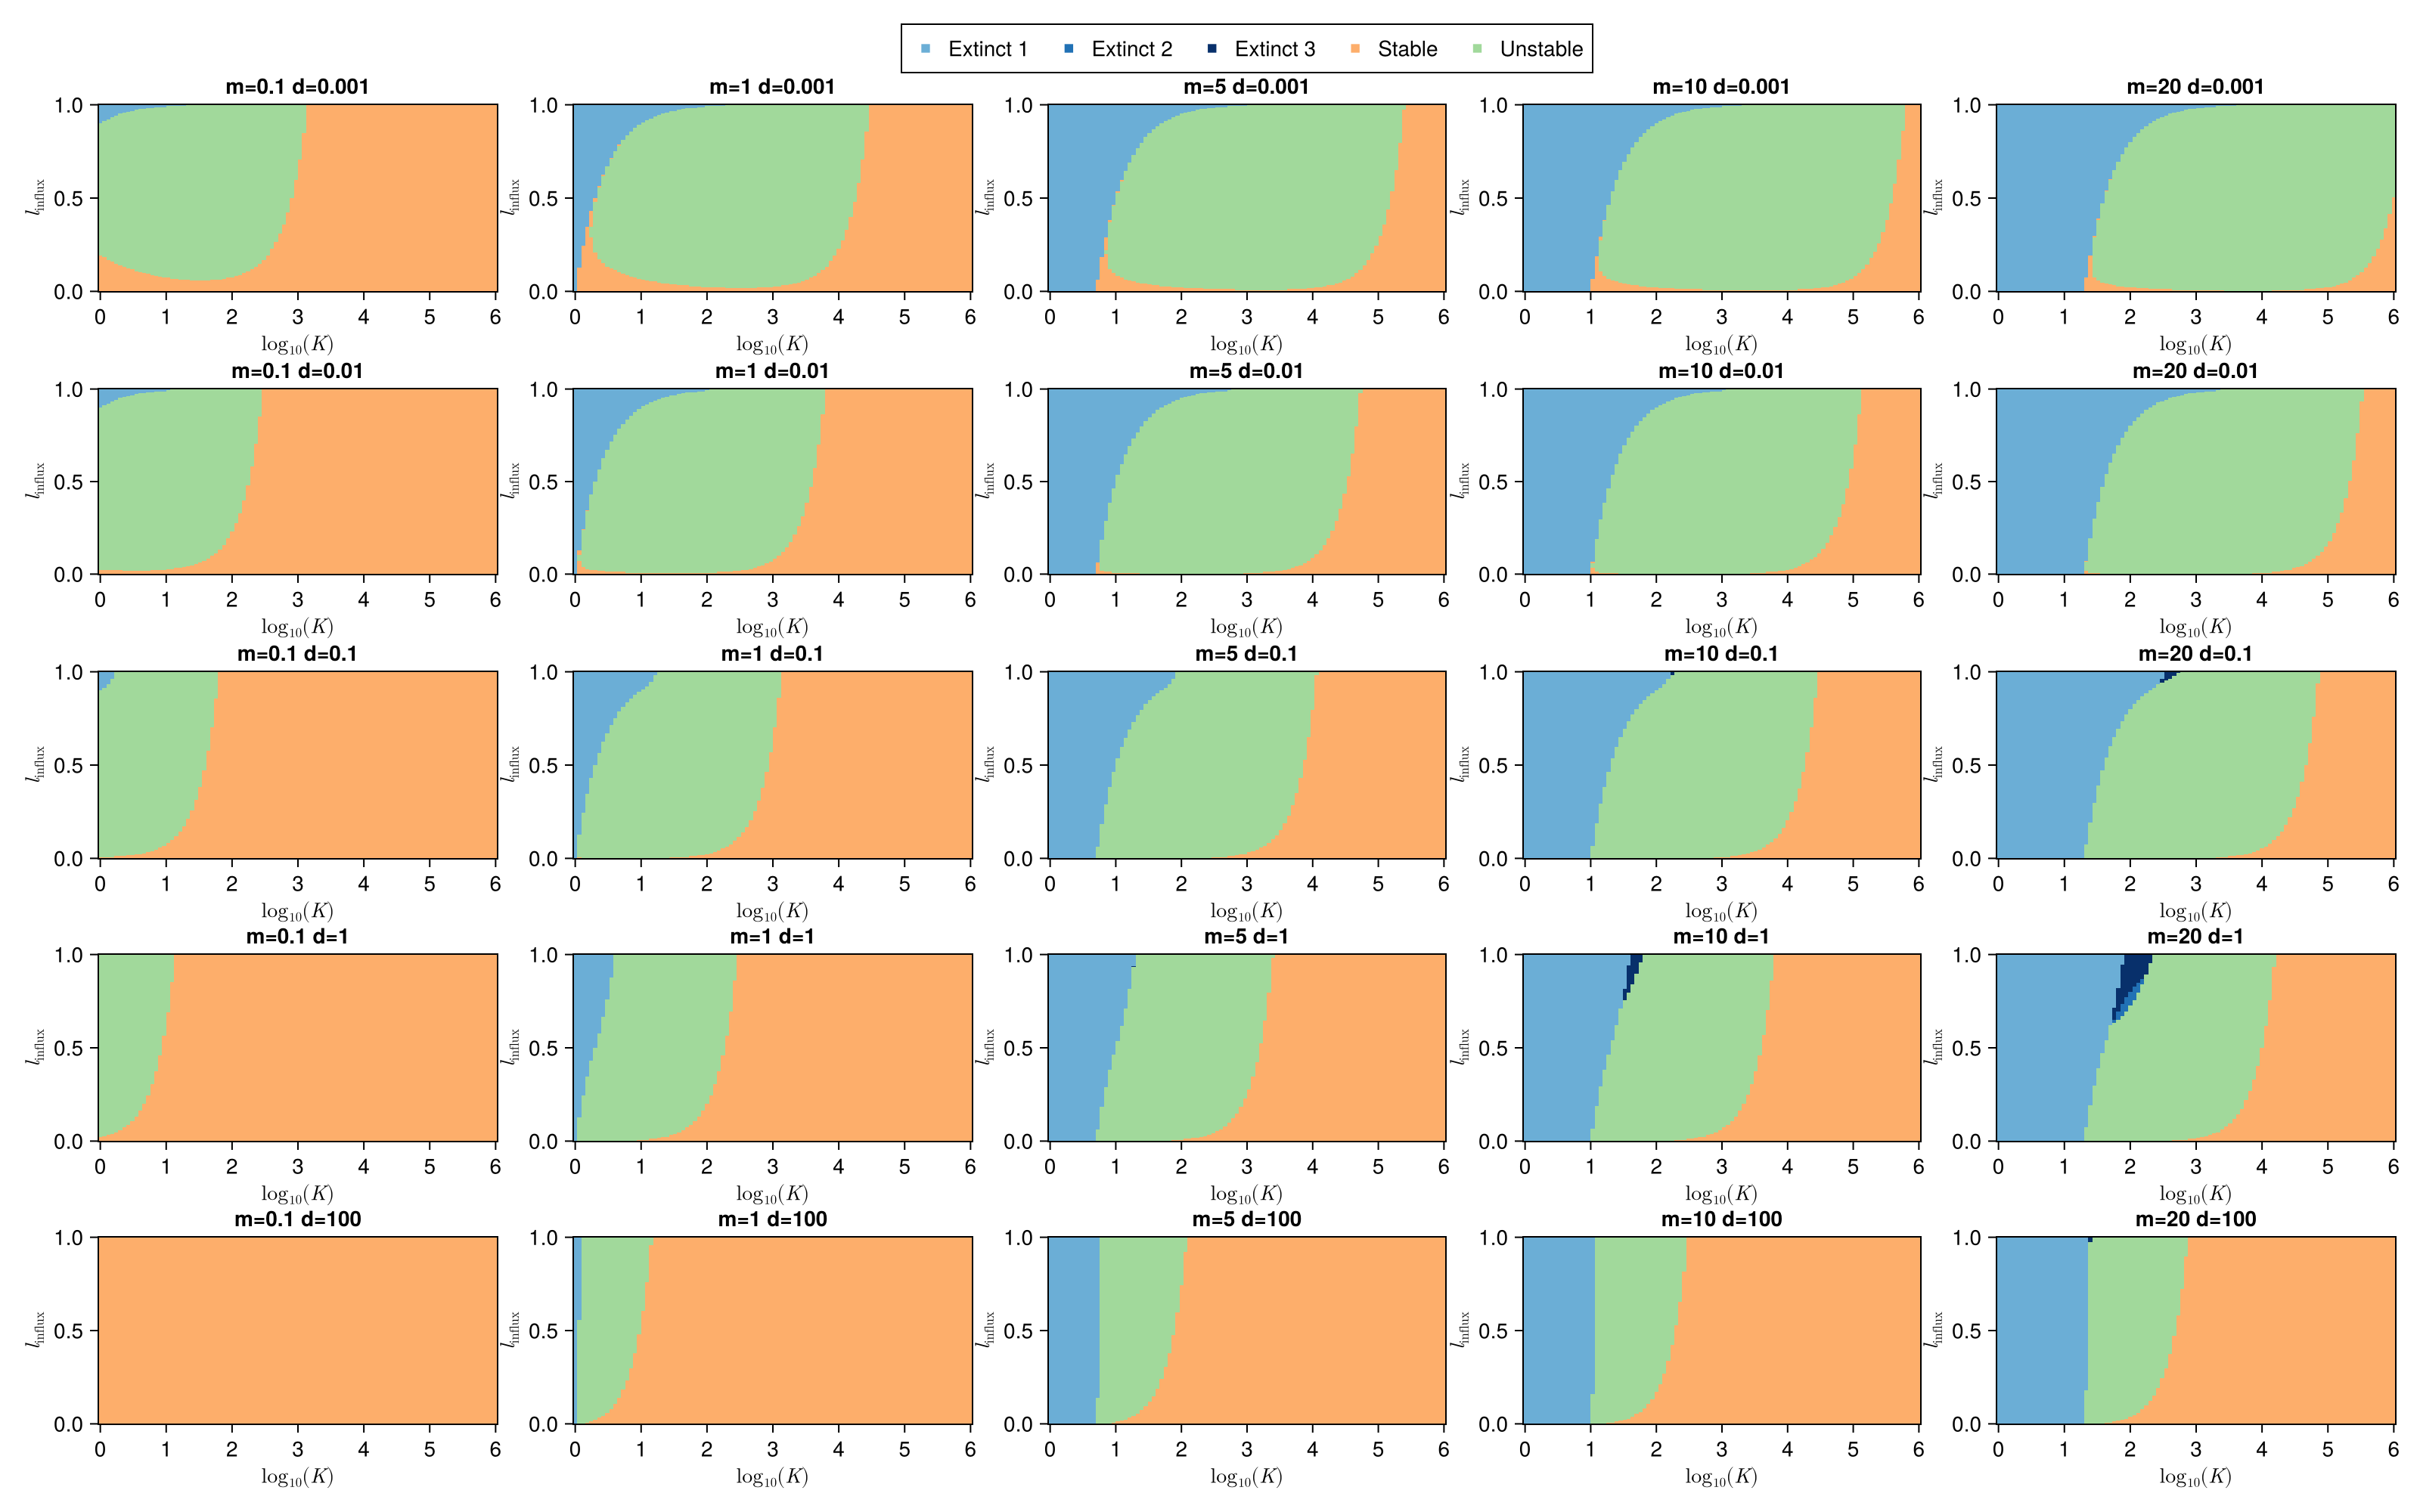

In [301]:
function tiling1()
    f = Figure(;
        size=(1600, 1000)
    )

    ms = range(0.1, 15, 5)
    ms = [0.1, 1, 5, 10, 20]
    # logds = range(-2, 3, 4)
    logds = [-3, -2, -1, 0, 2]

    axs = []
    for (i, m) in enumerate(ms)
        for (j, logd) in enumerate(logds)
            ax = Axis(f[j, i])

            d = 10. ^ logd
            plot_Kl_pd!(ax, range(0, 6, 100), range(0, 1, 200);
                m, d,
                # k=0.5,
                include_legend=false
            )
            ax.title = @sprintf "m=%.3g d=%.3g" m d
        end
    end
    
    Legend(f[0,:], mma_result_coloring2_leg()...;
        orientation=:horizontal
    )
    # Legend(f[:,(length(ms)+1)], leg[1], leg[2]; orientation=:horizontal)

    rowgap!(f.layout, 1.)
    colgap!(f.layout, 1.)

    f
end
xx = tiling1()

Makie.save("../../figures/fig2/tiling_md.pdf", xx)

xx

# Playground 1

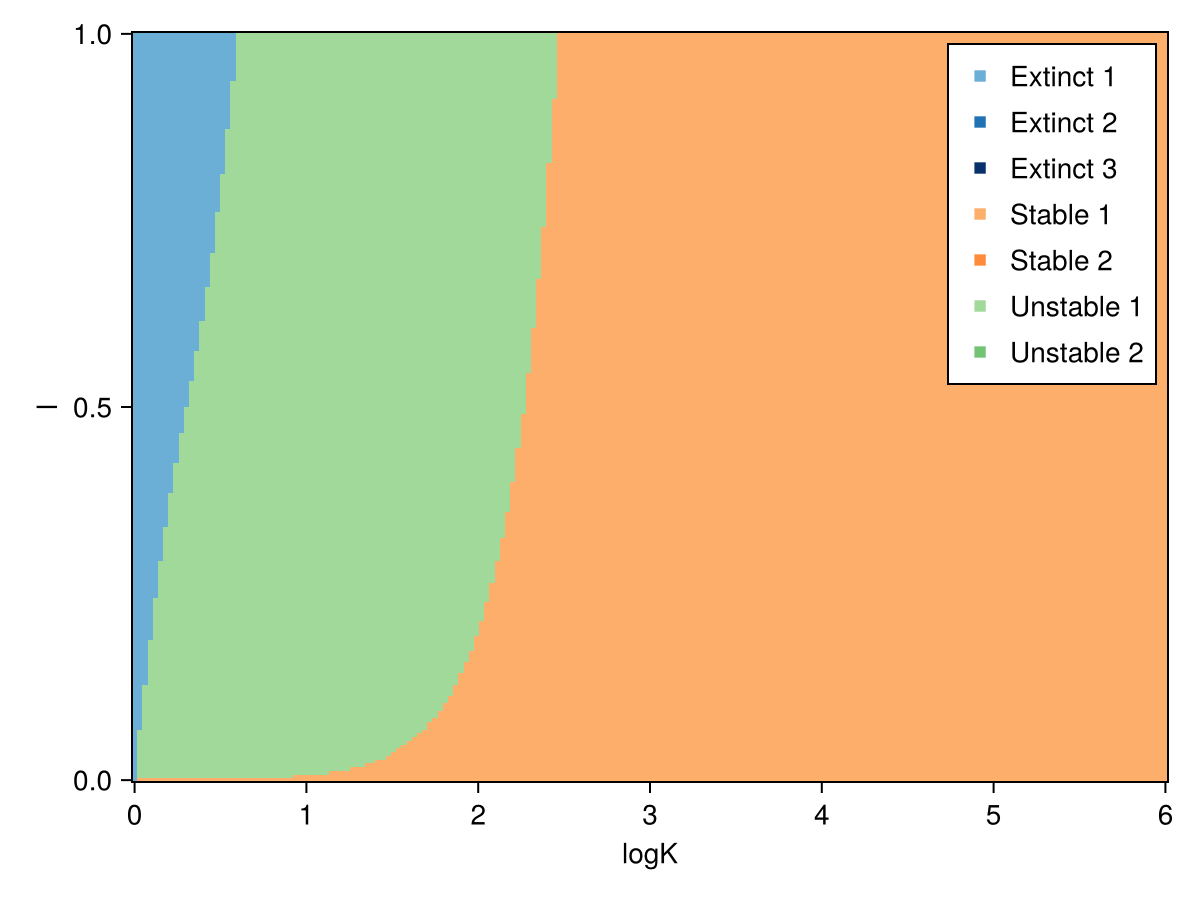

In [244]:
logKs = range(-0, 6, 200)
ls = range(0., 1., 200)

rslts = Matrix{Any}(undef, length(logKs), length(ls))
@tasks for i in 1:length(logKs)
    logK = logKs[i]
    for (j, l) in enumerate(ls)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=10 ^ logK,
                m=1.,
                l=l,
                k=0.,
                c=1.,
                d=1e0,
            );
            DN=1e-8, DI=1.0, DR=1e-8,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)
colors = mma_result_coloring2.(codes)

fap = heatmap(logKs, ls, colors;
    colormap=Categorical(:viridis),
    axis=(;
        # aspect=DataAspect(),
        xlabel="logK",
        ylabel="l",
    )
)
# Colorbar(fap.figure[1,2], fap.plot)
axislegend(fap.axis, MMAnalysisColors.legend_setup()...)

Makie.save("../../figures/fig2/pd_draft.pdf", fap)

fap

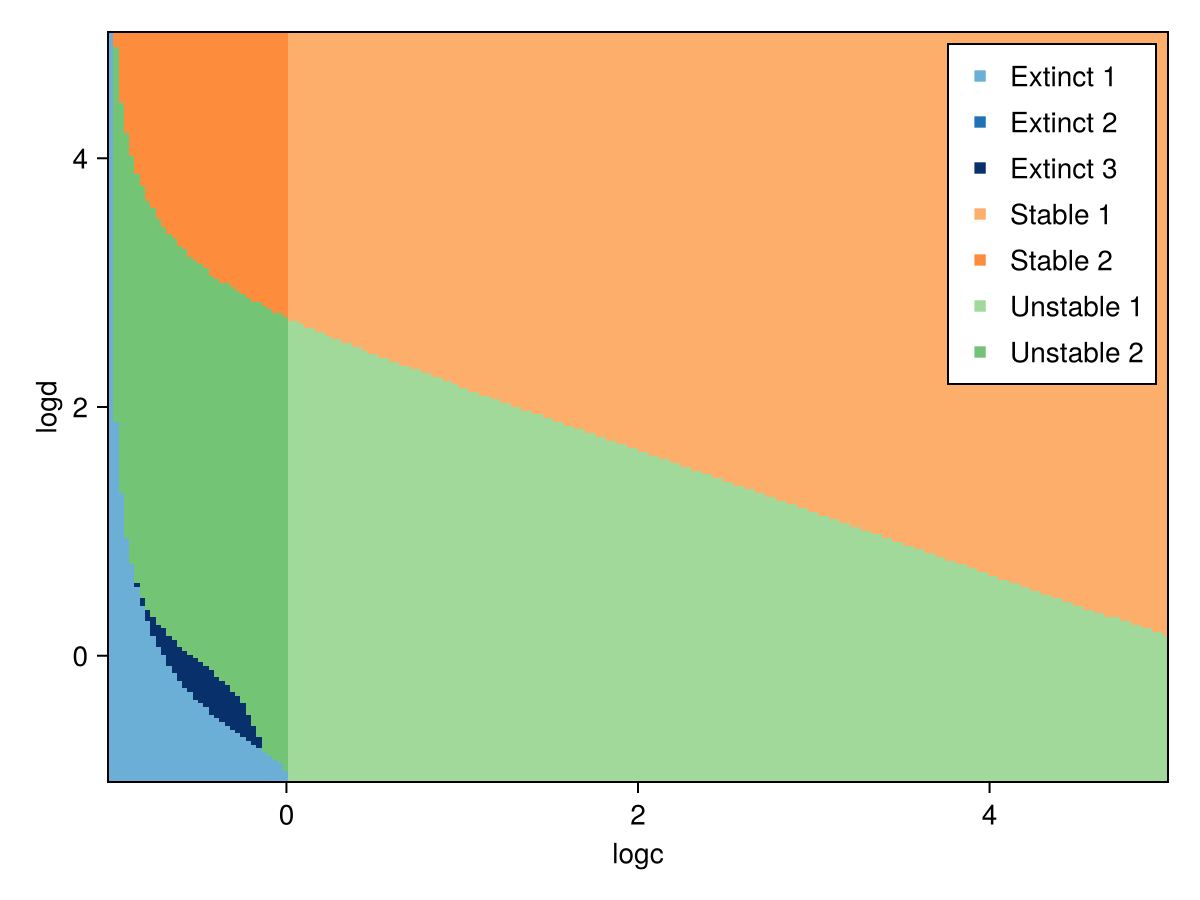

In [196]:
logcs = range(-1., 5., 200)
logds = range(-1., 5., 200)

rslts = Matrix{Any}(undef, length(logcs), length(logds))
@tasks for i in 1:length(logcs)
    logc = logcs[i]
    for (j, logd) in enumerate(logds)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=100.,
                m=10.,
                l=0.9,
                k=0.,
                c=10 ^ logc,
                d=10 ^ logd,
            );
            DN=1e-8, DI=1.0, DR=1e-8,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)
colors = mma_result_coloring1.(codes)

fap = heatmap(logcs, logds, colors;
    colormap=Categorical(:viridis),
    axis=(;
        # aspect=DataAspect(),
        xlabel="logc",
        ylabel="logd",
    )
)
# Colorbar(fap.figure[1,2], fap.plot)
axislegend(fap.axis, MMAnalysisColors.legend_setup()...)

Makie.save("../../figures/fig2/pd_draft.pdf", fap)

fap

# Raw results testing

In [3]:
mmp = MMParams(;
    K=1.,
    m=1.1,
    l=0.95,
    k=0.1,
    c=2.,
    d=1.,
)
# mm_get_nospace_sol(mmp)
analyse_mmp(mmp)

Any[]

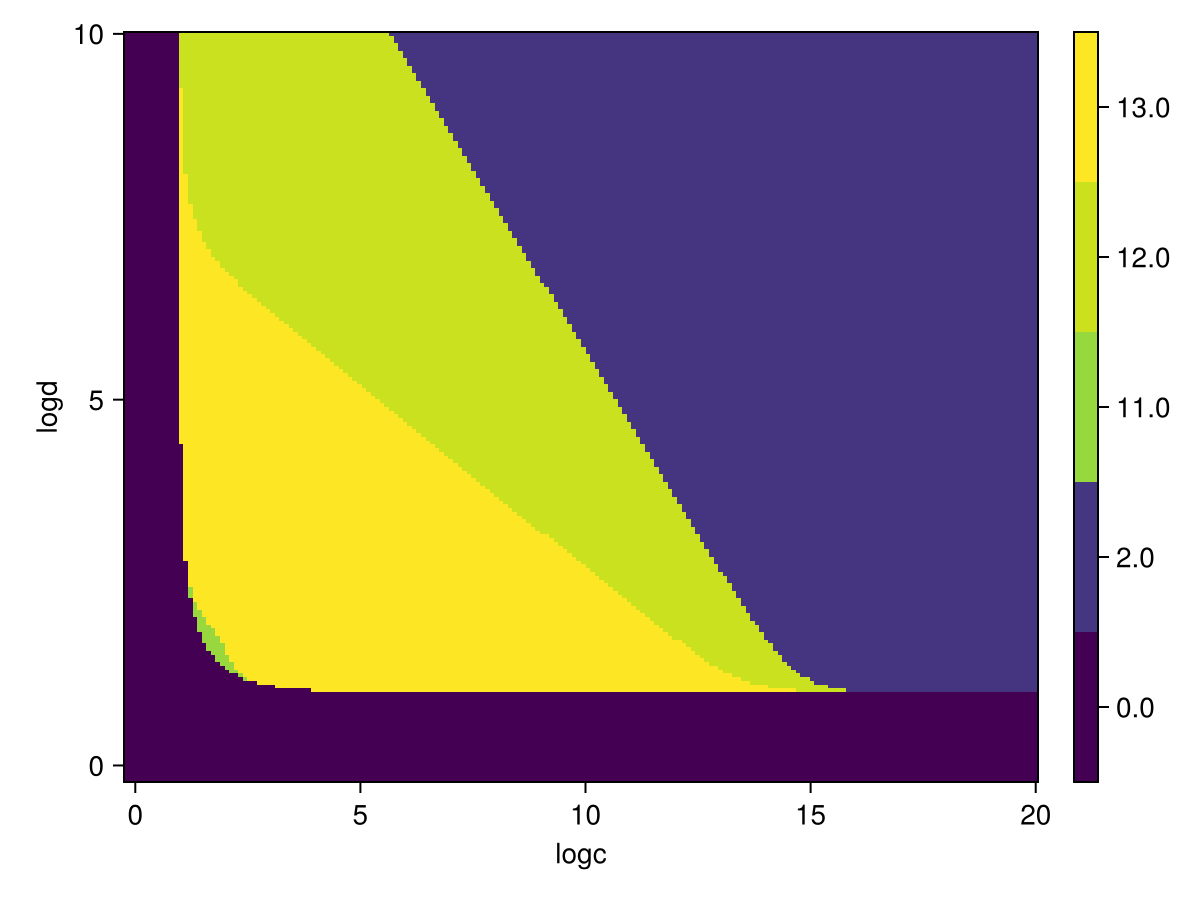

In [27]:
logcs = range(-0.2, 20, 200)
logds = range(-0.2, 10, 200)

rslts = Matrix{Any}(undef, length(logcs), length(logds))
for (i, logc) in enumerate(logcs)
    for (j, logd) in enumerate(logds)
        rslts[i, j] = analyse_mmp(
            MMParams(;
                K=1.,
                m=10.,
                l=1.,
                k=0.0,
                c=10 ^ logc,
                d=10 ^ logd,
            );
            DN=1e-12, DI=1.0, DR=1e-12,
        )
    end
end
codes = nospacesolstabilities_to_code.(rslts)

fap = heatmap(logcs, logds, codes;
    colormap=Categorical(:viridis),
    axis=(;
        xlabel="logc",
        ylabel="logd",
    )
)
Colorbar(fap.figure[1,2], fap.plot)

fap

In [18]:
nospacesolstabilities_list()

doesn't exist        <-> 0
nospace_unstable     <-> 1
stable               <-> 2
unstable             <-> 3


  0.000274 seconds (267 allocations: 21.266 KiB)


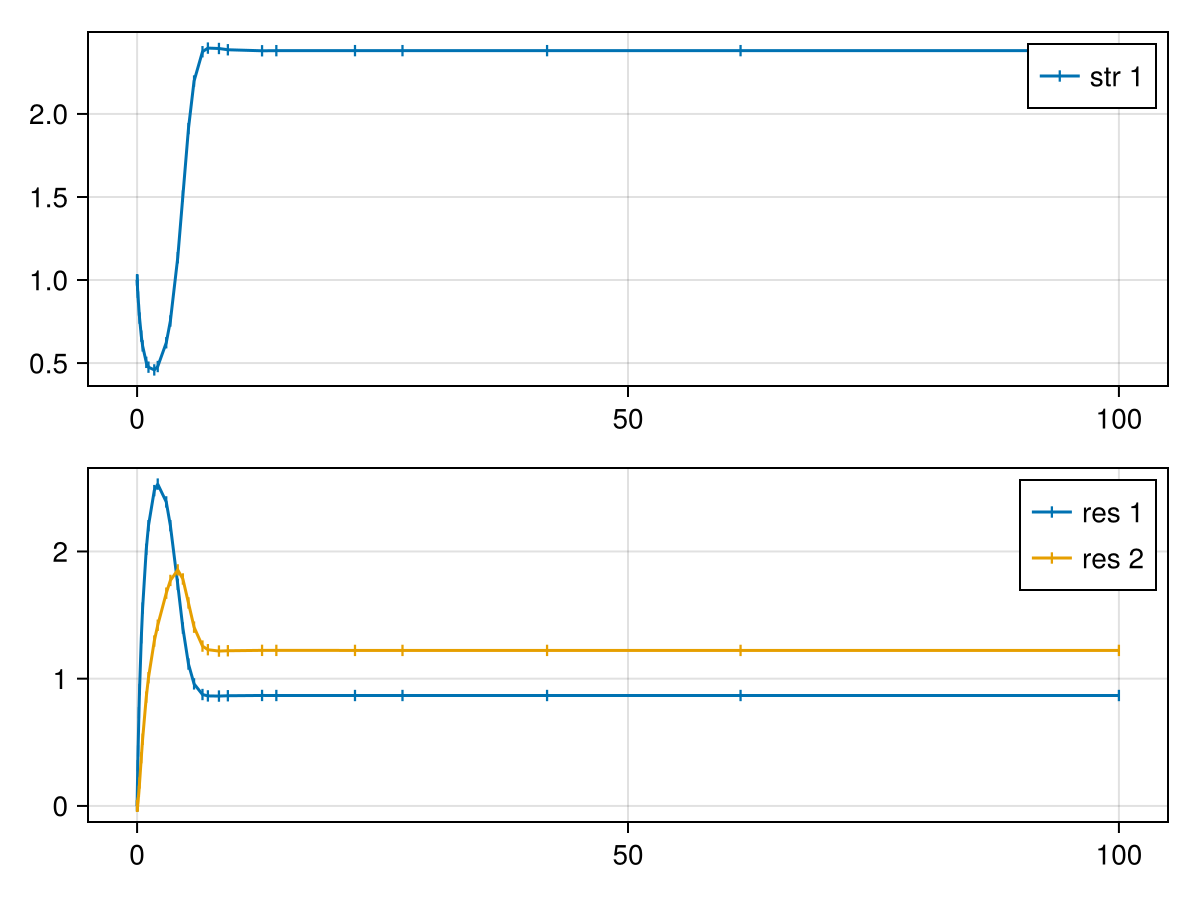

In [142]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 100);
# p = remake_guarantee_positive(p)

@time s = solve(p, TRBDF2();
    callback=make_timer_callback(1.)
)

# @show sort(s.u[end][1:N]; rev=true)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

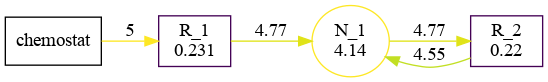

In [96]:
ss = clamp.(s.u[end], minimum(abs, s.u[end]), Inf)
# ss = mm_get_nospace_sol(mmp)[2]
diagram_sfss_v3(ps, ss;
    # strain_threshold=1e-3,
    # colorscale=log10,
)